In [37]:
#### Import necessary libraries

import torch
from torch import nn
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [38]:
#### Load and Prepare Data

X, y = fetch_olivetti_faces(
    data_home='data/',
    return_X_y=True
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

class FacesData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_data = FacesData(X_train, y_train)
test_data = FacesData(X_test, y_test)

train_loader = DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_data,
    shuffle=False,
    batch_size=32
)

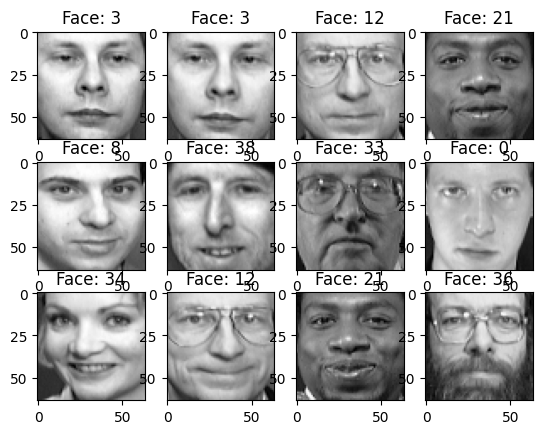

In [39]:
### View a sample of images

batch_idx, (data, targets) = next(enumerate(test_loader))

for i in range(12):
    plt.subplot(3, 4, i+1)
    img = data[i].reshape((64, 64))
    plt.imshow(img, cmap='gray')
    plt.title(f'Face: {targets[i]}')
plt.show()

In [40]:
data.shape

torch.Size([32, 4096])

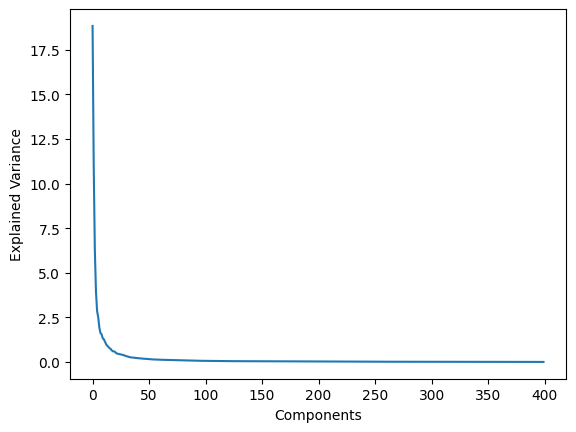

In [41]:
#### Perform PCA

pca = PCA()
pca.fit(X)
plt.plot(pca.explained_variance_)
plt.xlabel('Components')
plt.ylabel('Explained Variance')
plt.show()


In [42]:
#### Ideal components is 90

n_components = 90
pca = PCA(n_components=n_components)
pca.fit(X_train)
print(f'Feature shape before: {X_train.shape}')
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)
print(f'Feature shape after: {X_train_reduced.shape}')

train_data_reduced = FacesData(X_train_reduced, y_train)
test_data_reduced = FacesData(X_test_reduced, y_test)

train_loader_reduced = DataLoader(
    dataset=train_data_reduced,
    batch_size=32,
    shuffle=True
)

test_loader_reduced = DataLoader(
    dataset=test_data_reduced,
    shuffle=False,
    batch_size=32
)

Feature shape before: (280, 4096)
Feature shape after: (280, 90)


In [43]:
#### Define model architecture - Model V0

class ModelV0(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.sequential(x)

In [44]:
model_0 = ModelV0(90, 60, 40)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model_0.parameters(), lr=0.1)

In [45]:
model_0

ModelV0(
  (sequential): Sequential(
    (0): Linear(in_features=90, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=40, bias=True)
  )
)

In [46]:
#### Test sample forward pass

batch_idx, (data, targets) = next(enumerate(test_loader_reduced))
outputs = model_0(data)
predictions = torch.argmax(torch.sigmoid(outputs), dim=1)
print(f'Predictions for batch: {predictions}')

Predictions for batch: tensor([12, 12, 12, 15, 15, 37, 37, 30,  1, 12, 37, 15,  1, 15,  7, 15, 15, 12,
        12, 37, 12, 37, 12, 29, 12, 36,  1, 15, 12,  7,  1, 12])


In [47]:
#### Define Helper Functions

def accuracy_fn(y_pred, y):
    correct = torch.eq(y_pred, y).sum()
    return correct * 100. / len(y_pred)

def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn):
    train_loss, train_acc = 0, 0
    model.train()
    for batch_idx, (X, y) in enumerate(data_loader):
        y_logits = model(X)
        y_pred = torch.argmax(torch.sigmoid(y_logits), dim=1)
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_pred, y).item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f'Train loss: {train_loss:.5f} Train acc: {train_acc:.2f}%')
    return train_loss, train_acc

def test_step(model, data_loader, loss_fn, accuracy_fn):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_logits = model(X)
            y_pred = torch.argmax(torch.sigmoid(y_logits), dim=1)
            test_loss += loss_fn(y_logits, y)
            test_acc += accuracy_fn(y_pred, y).item()
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f'Test loss: {test_loss:.5f} Test acc: {test_acc:.2f}%')
    return test_loss, test_acc

def eval_mode(model, data_loader, loss_fn, accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_logits = model(X)
            y_pred = torch.argmax(torch.sigmoid(y_logits), dim=1)
            loss += loss_fn(y_logits, y).item()
            acc += accuracy_fn(y_pred, y)
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {
        'model_name': model.__class__.__name__,
        'model_loss': loss,
        'model_acc': acc.item()
    }

In [48]:
epochs = 40
train_losses, train_accs, test_losses, test_accs = [], [], [], []
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n---------')
    train_loss, train_acc = train_step(model_0, train_loader_reduced, loss_fn, optimizer, accuracy_fn)
    test_loss, test_acc = test_step(model_0, test_loader_reduced, loss_fn, accuracy_fn)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
results = eval_mode(model_0, test_loader_reduced, loss_fn, accuracy_fn)

100%|██████████| 40/40 [00:00<00:00, 240.88it/s]

Epoch: 0
---------
Train loss: 3.67217 Train acc: 2.78%
Test loss: 3.66821 Test acc: 3.12%
Epoch: 1
---------
Train loss: 3.60937 Train acc: 6.94%
Test loss: 3.63586 Test acc: 6.77%
Epoch: 2
---------
Train loss: 3.53590 Train acc: 15.05%
Test loss: 3.59419 Test acc: 7.81%
Epoch: 3
---------
Train loss: 3.43576 Train acc: 20.49%
Test loss: 3.53306 Test acc: 9.64%
Epoch: 4
---------
Train loss: 3.29955 Train acc: 21.99%
Test loss: 3.45816 Test acc: 8.85%
Epoch: 5
---------
Train loss: 3.13644 Train acc: 23.15%
Test loss: 3.38676 Test acc: 7.55%
Epoch: 6
---------
Train loss: 2.98088 Train acc: 24.65%
Test loss: 3.30891 Test acc: 11.72%
Epoch: 7
---------
Train loss: 2.83520 Train acc: 29.51%
Test loss: 3.22978 Test acc: 12.50%
Epoch: 8
---------
Train loss: 2.67293 Train acc: 34.26%
Test loss: 3.10927 Test acc: 19.79%
Epoch: 9
---------
Train loss: 2.49081 Train acc: 40.28%
Test loss: 3.00678 Test acc: 20.05%
Epoch: 10
---------
Train loss: 2.31600 Train acc: 40.97%
Test loss: 2.88287 T

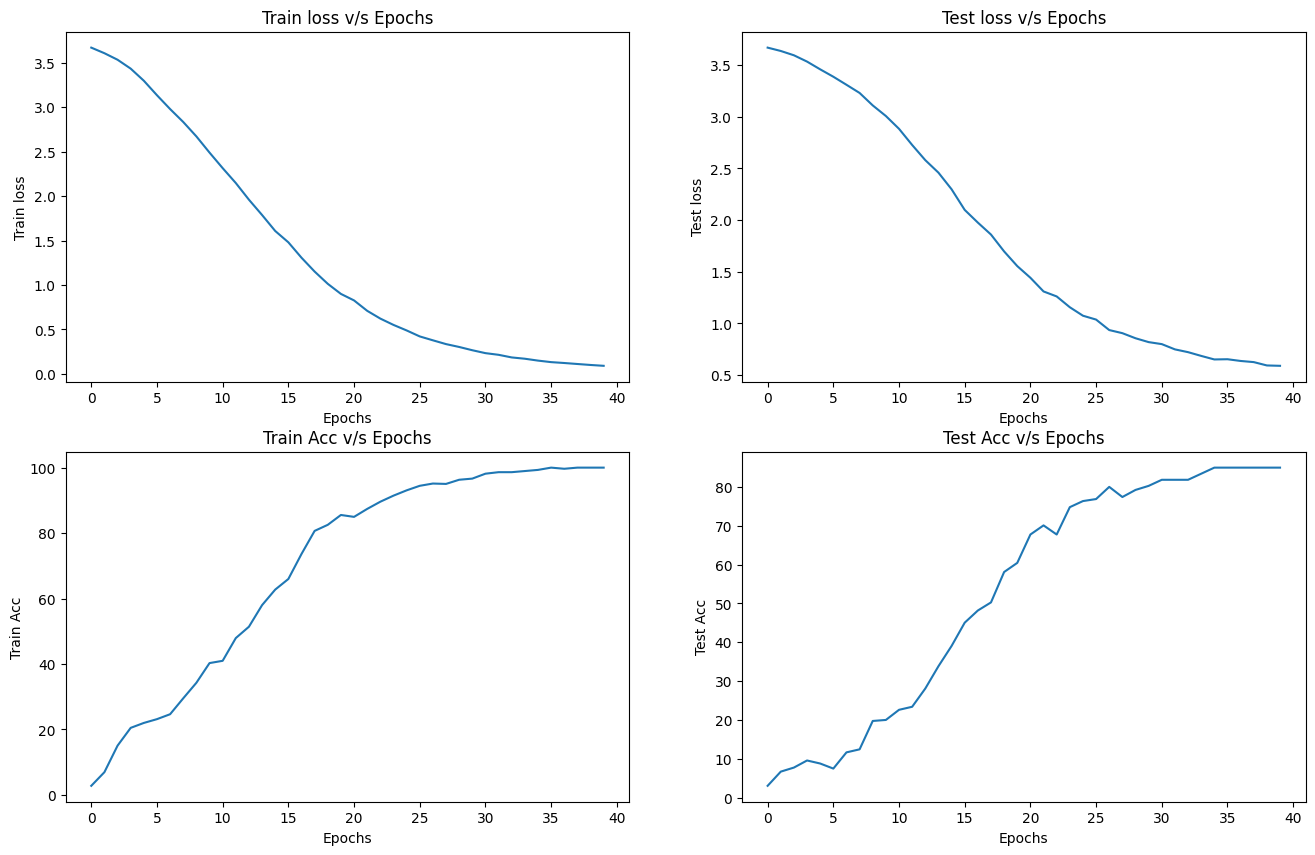

In [49]:
#### Plot loss and accuracy curves
epoch_counts = [i for i in range(epochs)]

plt.figure(figsize=(16, 10))
# Train loss curve
plt.subplot(2, 2, 1)
plt.plot(epoch_counts, train_losses)
plt.xlabel('Epochs')
plt.ylabel('Train loss')
plt.title('Train loss v/s Epochs')

# Test loss curve
plt.subplot(2, 2, 2)
plt.plot(epoch_counts, test_losses)
plt.xlabel('Epochs')
plt.ylabel('Test loss')
plt.title('Test loss v/s Epochs')

# Train acc curve
plt.subplot(2, 2, 3)
plt.plot(epoch_counts, train_accs)
plt.xlabel('Epochs')
plt.ylabel('Train Acc')
plt.title('Train Acc v/s Epochs')

# Test acc curve
plt.subplot(2, 2, 4)
plt.plot(epoch_counts, test_accs)
plt.xlabel('Epochs')
plt.ylabel('Test Acc')
plt.title('Test Acc v/s Epochs')
plt.show()

In [50]:
#### Make predictions

batch_idx, (batch_data, batch_targets) = next(enumerate(test_loader_reduced))
batch_data_rescaled = torch.matmul(batch_data,torch.from_numpy(pca.components_))
model_0.eval()
with torch.inference_mode():
    outputs = model_0(batch_data)
    predictions = torch.argmax(torch.sigmoid(outputs), dim=1)

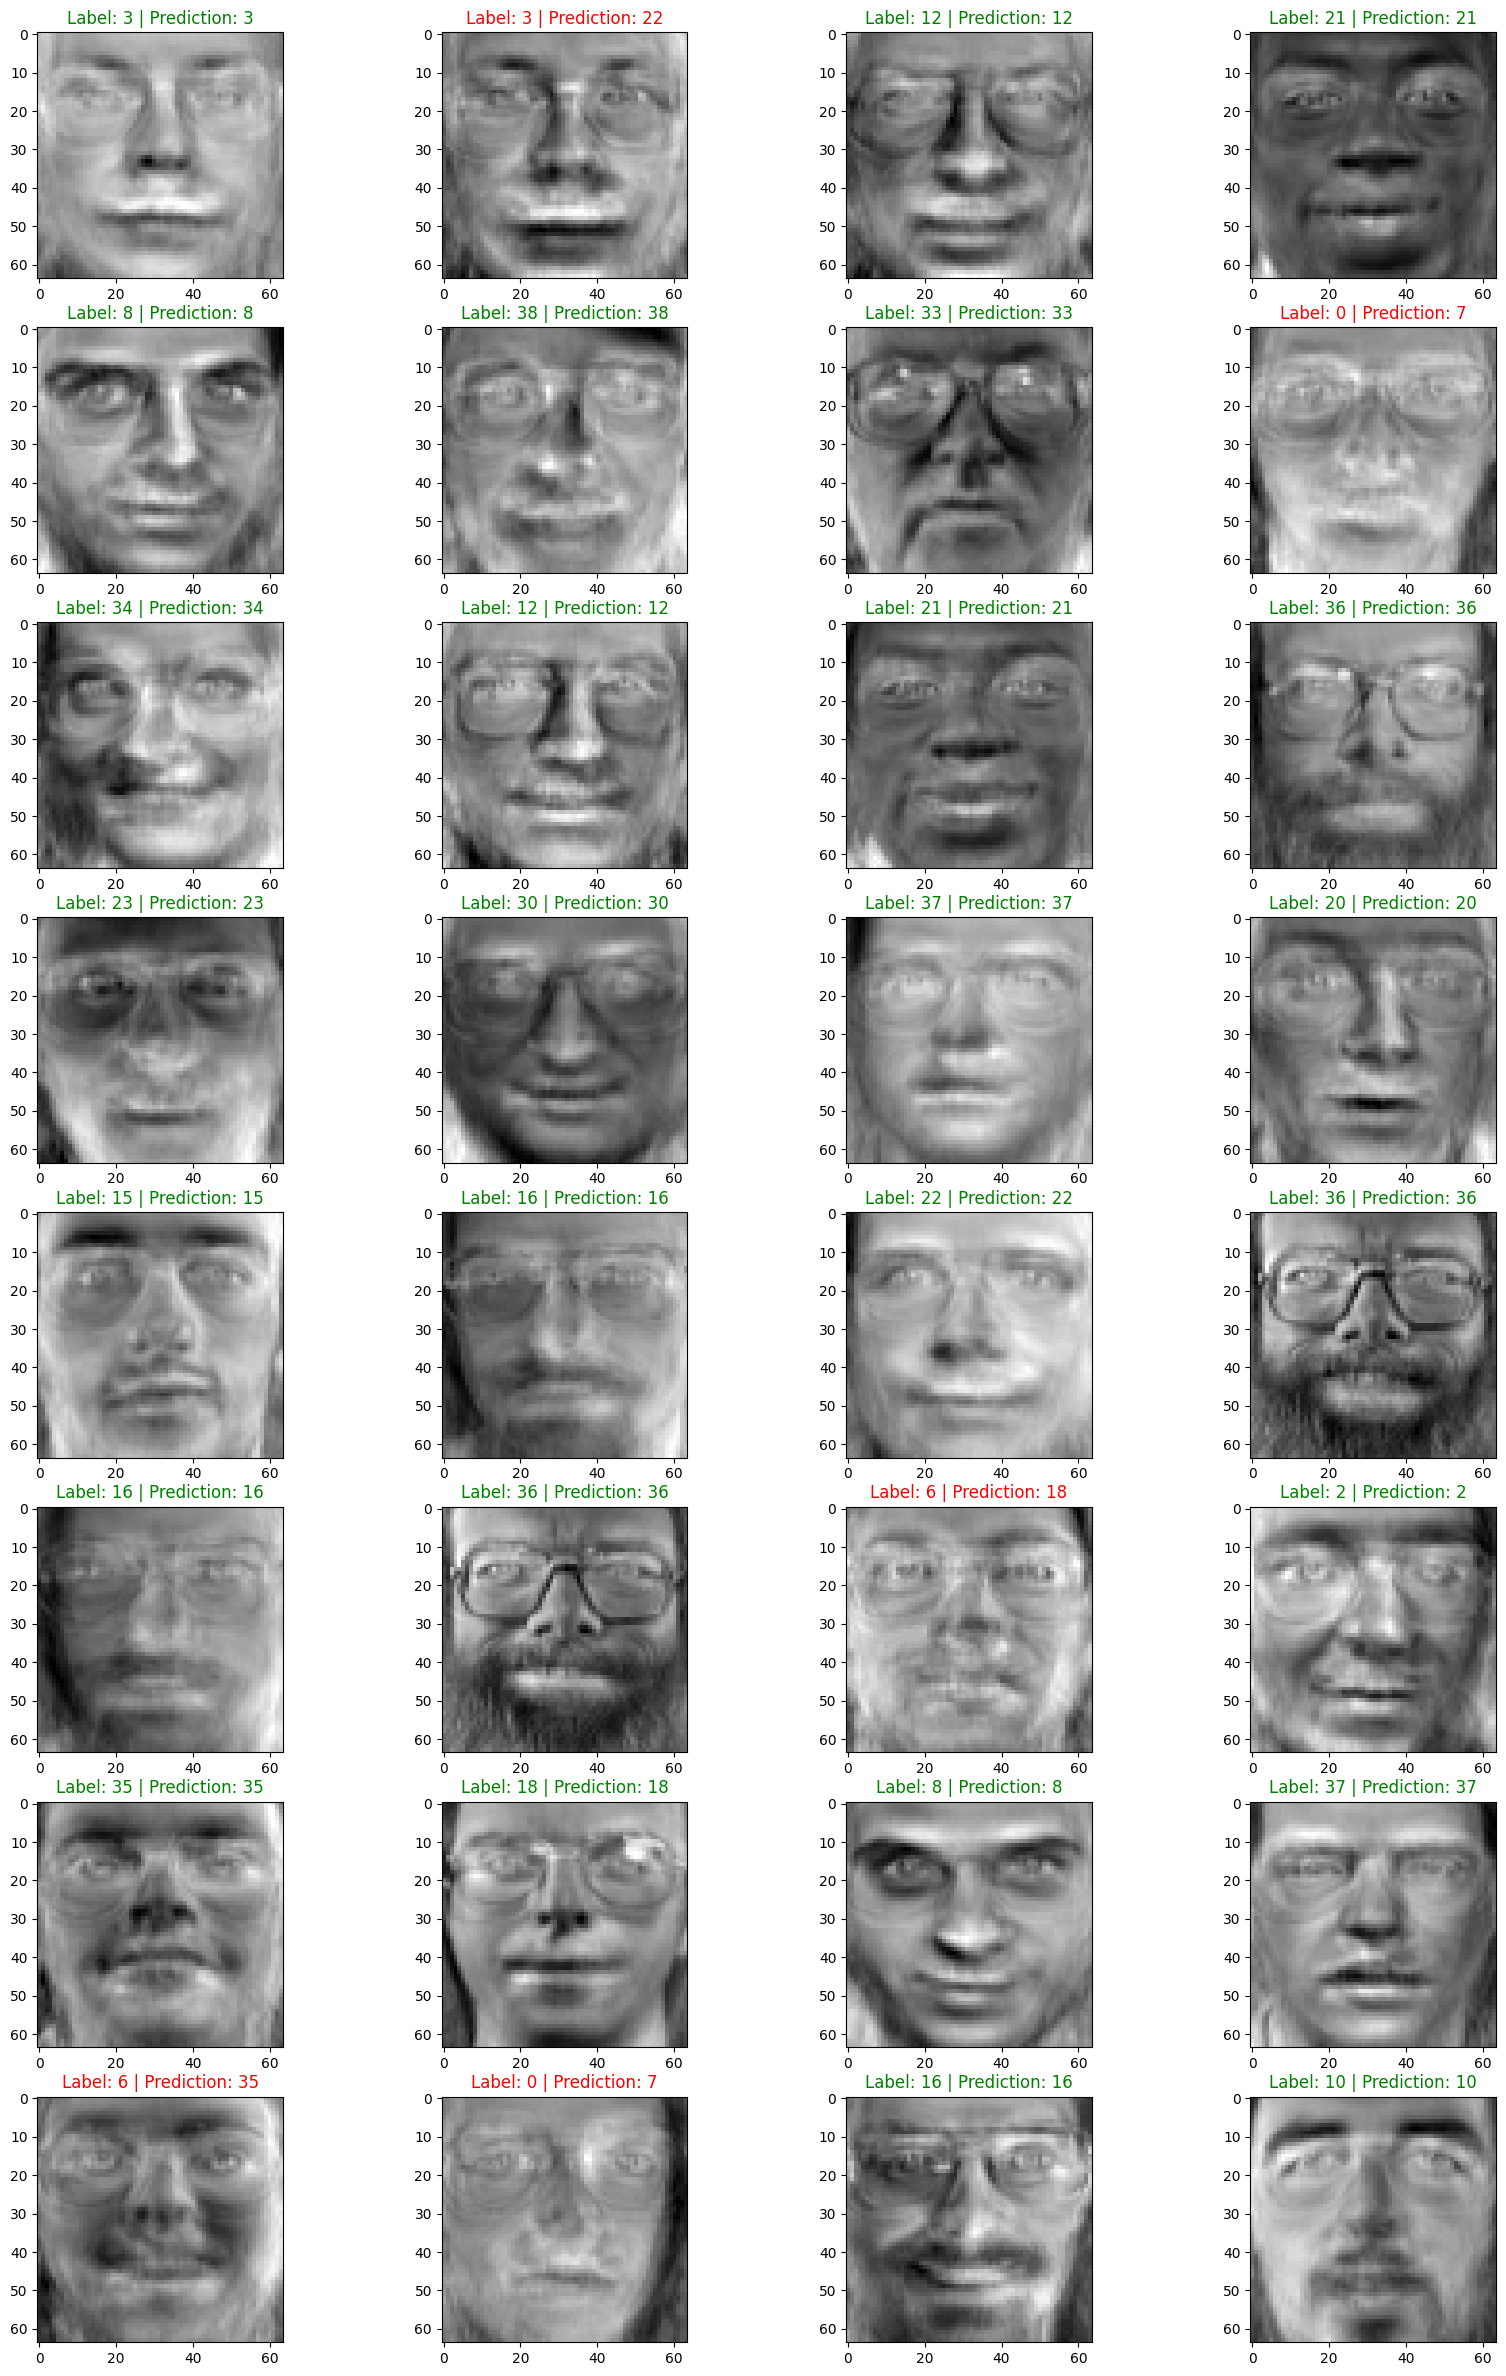

In [51]:
plt.figure(figsize=(20, 30))
for i in range(32):
    plt.subplot(8, 4, i+1)
    img = batch_data_rescaled[i].reshape((64, 64))
    plt.imshow(img, cmap='gray')
    label = batch_targets[i]
    prediction = predictions[i]
    if label == prediction:
        plt.title(f'Label: {batch_targets[i]} | Prediction: {predictions[i]}', color = 'green')
    else:
        plt.title(f'Label: {batch_targets[i]} | Prediction: {predictions[i]}', color = 'red')
plt.show()

In [52]:
#### Define Model Architecture (CNNs) - Model V1

class ModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*16*16, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 40)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.reshape((x.shape[0], 64 * 16 * 16))
        x = self.classifier(x)
        return x

In [53]:
model_1 = ModelV1()
model_1

ModelV1(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16384, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=40, bias=True)
  )
)

In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model_1.parameters(), lr=0.01)

In [55]:
#### Define Helper Functions

def accuracy_fn(y_pred, y):
    correct = torch.eq(y_pred, y).sum()
    return correct * 100. / len(y_pred)

def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn):
    train_loss, train_acc = 0, 0
    model.train()
    for batch_idx, (X, y) in enumerate(data_loader):
        X = X.reshape((X.shape[0], 1, 64, 64))
        y_logits = model(X)
        y_pred = torch.argmax(y_logits, dim=1)
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_pred, y).item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f'Train loss: {train_loss:.5f} Train acc: {train_acc:.2f}%')
    return train_loss, train_acc

def test_step(model, data_loader, loss_fn, accuracy_fn):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X = X.reshape((X.shape[0], 1, 64, 64))
            y_logits = model(X)
            y_pred = torch.argmax(y_logits, dim=1)
            test_loss += loss_fn(y_logits, y)
            test_acc += accuracy_fn(y_pred, y).item()
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f'Test loss: {test_loss:.5f} Test acc: {test_acc:.2f}%')
    return test_loss, test_acc

def eval_mode(model, data_loader, loss_fn, accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X = X.reshape((X.shape[0], 1, 64, 64))
            y_logits = model(X)
            y_pred = torch.argmax(y_logits, dim=1)
            loss += loss_fn(y_logits, y).item()
            acc += accuracy_fn(y_pred, y)
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {
        'model_name': model.__class__.__name__,
        'model_loss': loss,
        'model_acc': acc.item()
    }

In [ ]:
epochs = 10
train_losses, train_accs, test_losses, test_accs = [], [], [], []
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n---------')
    train_loss, train_acc = train_step(model_1, train_loader, loss_fn, optimizer, accuracy_fn)
    test_loss, test_acc = test_step(model_1, test_loader, loss_fn, accuracy_fn)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
results = eval_mode(model_1, test_loader, loss_fn, accuracy_fn)

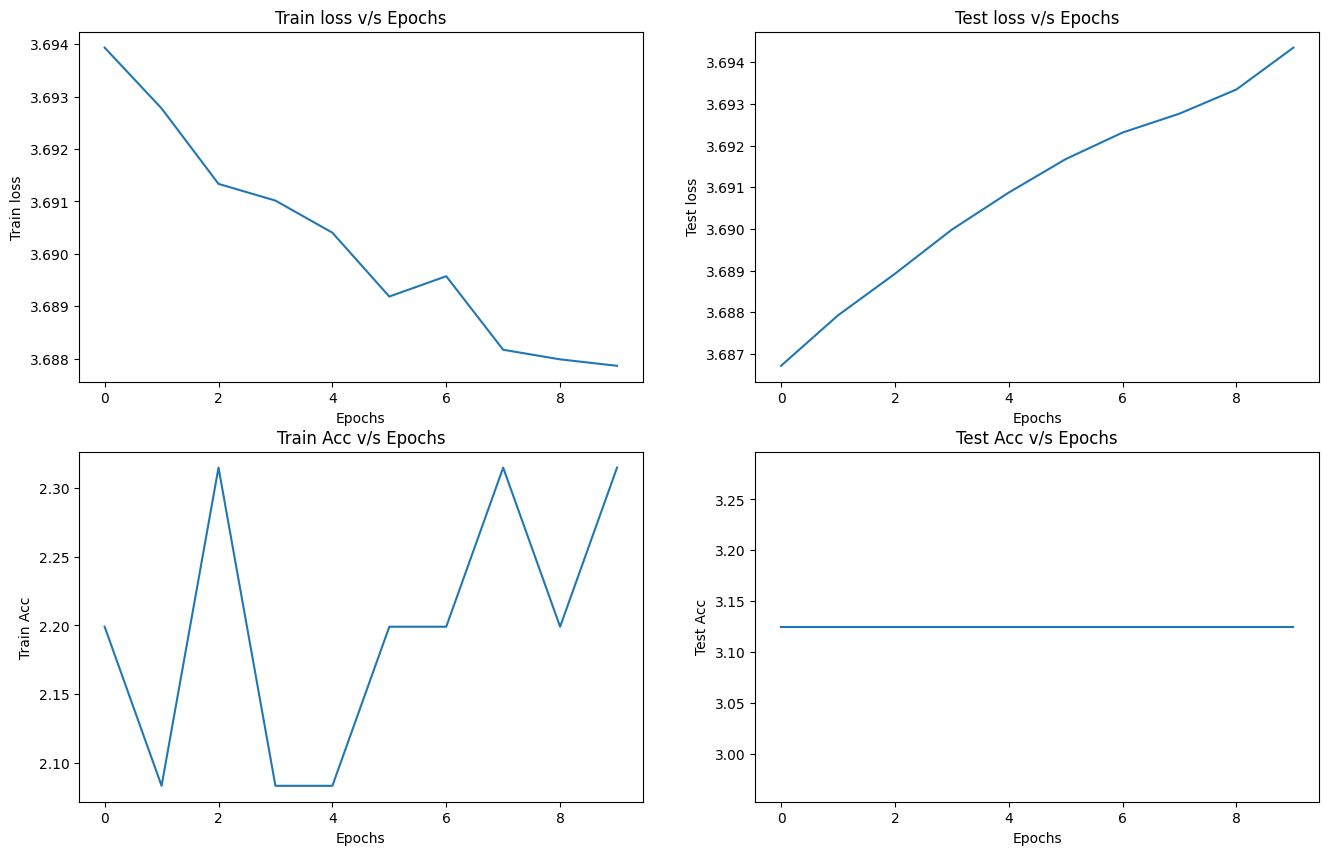

In [36]:
#### Plot loss and accuracy curves
epoch_counts = [i for i in range(epochs)]

plt.figure(figsize=(16, 10))
# Train loss curve
plt.subplot(2, 2, 1)
plt.plot(epoch_counts, train_losses)
plt.xlabel('Epochs')
plt.ylabel('Train loss')
plt.title('Train loss v/s Epochs')

# Test loss curve
plt.subplot(2, 2, 2)
plt.plot(epoch_counts, test_losses)
plt.xlabel('Epochs')
plt.ylabel('Test loss')
plt.title('Test loss v/s Epochs')

# Train acc curve
plt.subplot(2, 2, 3)
plt.plot(epoch_counts, train_accs)
plt.xlabel('Epochs')
plt.ylabel('Train Acc')
plt.title('Train Acc v/s Epochs')

# Test acc curve
plt.subplot(2, 2, 4)
plt.plot(epoch_counts, test_accs)
plt.xlabel('Epochs')
plt.ylabel('Test Acc')
plt.title('Test Acc v/s Epochs')
plt.show()